# Import Package

In [11]:
# Numerical Operations
import random
import math
import numpy as np

# Reading/Writting Data
import pandas as pd
import os
import cv2

# For Pragress Bar
from tqdm import tqdm

# Pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
from torchsummary import summary


# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

# For spiliting the data to train and test
from sklearn.model_selection import train_test_split

# Config

In [69]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'seed': 5201314,  
    'valid_ratio': 0.2,  
    'n_epochs': 200,               
    'batch_size': 50, 
    'learning_rate': 0.001,              
    'early_stop': 10,       
    'save_path': './model/model.ckpt', 
    'raw_img_path': './raw_images',
    'processed_img_path': './processed_images',
    'labels': 'labels.csv'
}

# Some Utility Function

In [62]:
def same_seed(seed):
    random.seed(seed) 
    np.random.seed(seed)  
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

def train_valid_split(data_set, valid_ratio, seed):
    valid_set_size = int(valid_ratio * len(data_set)) 
    train_set_size = len(data_set) - valid_set_size
    train_set, valid_set = random_split(data_set, 
                                        [train_set_size, valid_set_size], 
                                        generator=torch.Generator().manual_seed(seed))
    return np.array(train_set), np.array(valid_set)

def caculate_acc(outputs, labels):
    rightness = 0
    a_word = outputs.size()[1] // 4
    for output_row, label_row in zip(outputs, labels):
        output_index = []
        label_index = []
        for start in range(0, outputs.size()[1], a_word):
            output_index.append(torch.max(output_row[start:start + a_word], 0)[1].item())
            label_index.append(torch.max(label_row[start:start + a_word], 0)[1].item())
        if output_index == label_index:
            rightness += 1
    return rightness

def preprocess(label_file, img_num, img_path, valid_ratio, seed):
    labels = pd.read_csv(label_file).iloc[:, -1].values
    captcha_list = ['2', '3', '4', '5', '6', '7', '8', '9', 
                    'A', 'C', 'D', 'E', 'F', 'G', 'H', 'K', 
                    'M', 'N', 'P', 'Q', 'R', 'T', 'V', 'W', 'Y', 'Z']
    
    all_labels = [] # Y
    all_images = [] # X
    for label in labels[0: img_num]:
        one_hot = np.zeros([len(label) * len(captcha_list)], dtype=float)
        for j, char in enumerate(label):
            index = j * len(captcha_list) + captcha_list.index(char)
            one_hot[index] = 1.0
        all_labels.append(one_hot)
        
    for idx in range(1, img_num + 1):
        # read image
        img = cv2.imread(img_path + '/' + str(idx) + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).reshape([1, 48, 144])
        all_images.append(img)
        
    Y = np.array(all_labels) # Y.shape = [5000, 104]
    X = np.array(all_images, dtype = float) # X.shape = [5000, 1, 48, 144]
    X = X / 255 #standerlize
    x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size=valid_ratio, random_state=seed)
    return x_train, x_valid, y_train, y_valid

# Model

In [68]:
image_size  = [48, 144]
num_classes = 104 
depth = [8, 16, 128, 256] 

class ConvNet(nn.Module):
    def __init__(self, ):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, depth[0], 3, padding = 1) 
        self.pool1 = nn.MaxPool2d(2, 2) 
        self.conv2 = nn.Conv2d(depth[0], depth[1], 5, padding = 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(depth[1], depth[2], 5, padding = 2)
        self.conv4 = nn.Conv2d(depth[2], depth[3], 5, padding = 2)
        self.fc1 = nn.Linear(image_size[0]//4 * image_size[1]//4 * depth[3] , 512)
        self.fc2 = nn.Linear(512, num_classes) 
        

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(-1, image_size[0]//4 * image_size[1]//4 * depth[3])
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training) 
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

    def retrieve_features(self, x):
        tempx1 = F.relu(self.conv1(x)) 
        tempx2 = F.relu(self.conv2(self.pool1(tempx1))) 
        tempx3 = F.relu(self.conv3(self.pool2(tempx2)))
        tempx1 = tempx1.detach().cpu()
        tempx2 = tempx2.detach().cpu()
        tempx3 = tempx3.detach().cpu()
        return (tempx1, tempx2, tempx3)

summary(ConvNet(), (1, 48, 144), 1, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 8, 48, 144]              80
         MaxPool2d-2             [1, 8, 24, 72]               0
            Conv2d-3            [1, 16, 24, 72]           3,216
         MaxPool2d-4            [1, 16, 12, 36]               0
            Conv2d-5            [1, 64, 12, 36]          25,664
            Conv2d-6           [1, 128, 12, 36]         204,928
            Linear-7                   [1, 512]      28,312,064
            Linear-8                   [1, 104]          53,352
Total params: 28,599,304
Trainable params: 28,599,304
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 1.43
Params size (MB): 109.10
Estimated Total Size (MB): 110.55
----------------------------------------------------------------


# Dataset

In [64]:
class CaptchaDataset(Dataset):
    def __init__(self, X, y=None):
        self.data = torch.FloatTensor(X)
        if y is not None:
            self.label = torch.FloatTensor(y)
        else:
            self.label = None

    def __getitem__(self, idx):
        if self.label is not None:
            return self.data[idx], self.label[idx]
        else:
            return self.data[idx]

    def __len__(self):
        return len(self.data)

# Dataloader

In [70]:
same_seed(config['seed'])

x_train, x_valid, y_train, y_valid = preprocess(label_file=config['labels'], 
                                                img_num=5000, img_path=config['processed_img_path'], 
                                                valid_ratio=config['valid_ratio'], 
                                                seed=config['seed'])
train_dataset, valid_dataset = CaptchaDataset(x_train, y_train), CaptchaDataset(x_valid, y_valid)
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)

# Training

In [78]:
model = ConvNet().to(device) 
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0
writer = SummaryWriter()

if not os.path.exists('model'):
    os.mkdir('model')

loss_record = [] # (train_loss, valid_loss)
acc_record = [] # (train_acc, valid_acc)
best_acc = 0.0

for epoch in range(config['n_epochs']):
    train_acc = 0.0
    train_loss_record = []
    val_acc = 0.0
    val_loss_record = []
    
    # training
    model.train() # set the model to training mode
    for i, batch in enumerate(tqdm(train_loader)):
        features, labels = batch
        features = features.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad() 
        outputs = model(features) 
        
        loss = criterion(outputs, labels)
        loss.backward() 
        optimizer.step()
        step += 1
        
        train_acc += caculate_acc(outputs, labels)
        train_loss_record.append(loss.item())
    mean_train_loss = sum(train_loss_record) / len(train_loss_record)

    # validation
    model.eval() # set the model to evaluation mode
    with torch.no_grad():
        for i, batch in enumerate(tqdm(valid_loader)):
            features, labels = batch
            features = features.to(device)
            labels = labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels) 
            val_acc += caculate_acc(outputs, labels)
            val_loss_record.append(loss.item())
        mean_valid_loss = sum(val_loss_record) / len(val_loss_record)
        writer.add_scalars('Loss', {'train': mean_train_loss, 'valid': mean_valid_loss}, epoch)
        loss_record.append((mean_train_loss, mean_valid_loss))
    
    acc_record.append((train_acc/len(train_dataset), val_acc/len(valid_dataset)))   
    print(f'[{epoch+1:03d}/{n_epochs:03d}] Train Acc: {train_acc/len(train_dataset):3.5f} \
          Loss: {mean_train_loss:3.5f} | Val Acc: {val_acc/len(valid_dataset):3.5f} loss: {mean_valid_loss:3.5f}')

    # if the model improves, save a checkpoint at this epoch
    '''
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), config['save_path'])
        print(f'saving model with acc {best_acc/len(valid_dataset):.5f}')
        early_stop_count = 0
    '''
    
    if mean_valid_loss < best_loss:
        best_loss = mean_valid_loss
        torch.save(model.state_dict(), config['save_path'])
        print(f'saving model with acc {val_acc/len(valid_dataset):.5f}')
        early_stop_count = 0
    else: 
        early_stop_count += 1
    if early_stop_count >= config['early_stop']:
        print('\nModel is not improving, so we halt the training session.')
        break

100%|██████████| 20/20 [00:01<00:00, 16.78it/s]


[001/200] Train Acc: 0.00000           Loss: 0.17915 | Val Acc: 0.00000 loss: 0.15175
saving model with acc 0.00000


100%|██████████| 20/20 [00:01<00:00, 15.69it/s]


[002/200] Train Acc: 0.00000           Loss: 0.15523 | Val Acc: 0.00000 loss: 0.14893
saving model with acc 0.00000


100%|██████████| 20/20 [00:01<00:00, 15.56it/s]


[003/200] Train Acc: 0.00700           Loss: 0.12962 | Val Acc: 0.10100 loss: 0.09365
saving model with acc 0.10100


100%|██████████| 20/20 [00:01<00:00, 15.56it/s]


[004/200] Train Acc: 0.06825           Loss: 0.09259 | Val Acc: 0.26700 loss: 0.07008
saving model with acc 0.26700


100%|██████████| 20/20 [00:01<00:00, 14.38it/s]


[005/200] Train Acc: 0.21325           Loss: 0.07132 | Val Acc: 0.48900 loss: 0.05130
saving model with acc 0.48900


100%|██████████| 20/20 [00:01<00:00, 15.60it/s]


[006/200] Train Acc: 0.40275           Loss: 0.05425 | Val Acc: 0.68500 loss: 0.03889
saving model with acc 0.68500


100%|██████████| 20/20 [00:01<00:00, 15.73it/s]


[007/200] Train Acc: 0.55025           Loss: 0.04225 | Val Acc: 0.79700 loss: 0.02779
saving model with acc 0.79700


100%|██████████| 20/20 [00:01<00:00, 15.41it/s]


[008/200] Train Acc: 0.65100           Loss: 0.03445 | Val Acc: 0.84800 loss: 0.02484
saving model with acc 0.84800


100%|██████████| 20/20 [00:01<00:00, 13.58it/s]


[009/200] Train Acc: 0.72550           Loss: 0.02908 | Val Acc: 0.86900 loss: 0.02359
saving model with acc 0.86900


100%|██████████| 20/20 [00:01<00:00, 15.37it/s]


[010/200] Train Acc: 0.77325           Loss: 0.02515 | Val Acc: 0.90200 loss: 0.02003
saving model with acc 0.90200


100%|██████████| 20/20 [00:01<00:00, 14.01it/s]


[011/200] Train Acc: 0.80425           Loss: 0.02186 | Val Acc: 0.90800 loss: 0.01894
saving model with acc 0.90800


100%|██████████| 20/20 [00:01<00:00, 15.78it/s]


[012/200] Train Acc: 0.84525           Loss: 0.01958 | Val Acc: 0.92200 loss: 0.01710
saving model with acc 0.92200


100%|██████████| 20/20 [00:01<00:00, 15.61it/s]


[013/200] Train Acc: 0.86200           Loss: 0.01802 | Val Acc: 0.91900 loss: 0.01751


100%|██████████| 20/20 [00:01<00:00, 14.61it/s]


[014/200] Train Acc: 0.87225           Loss: 0.01677 | Val Acc: 0.92300 loss: 0.01667
saving model with acc 0.92300


100%|██████████| 20/20 [00:01<00:00, 14.05it/s]


[015/200] Train Acc: 0.88500           Loss: 0.01551 | Val Acc: 0.93000 loss: 0.01679


100%|██████████| 20/20 [00:01<00:00, 14.96it/s]


[016/200] Train Acc: 0.88875           Loss: 0.01499 | Val Acc: 0.93200 loss: 0.01678


100%|██████████| 20/20 [00:01<00:00, 14.37it/s]


[017/200] Train Acc: 0.90100           Loss: 0.01377 | Val Acc: 0.92200 loss: 0.01698


100%|██████████| 20/20 [00:01<00:00, 15.45it/s]


[018/200] Train Acc: 0.91175           Loss: 0.01294 | Val Acc: 0.93300 loss: 0.01679


100%|██████████| 20/20 [00:01<00:00, 15.55it/s]


[019/200] Train Acc: 0.91975           Loss: 0.01238 | Val Acc: 0.93500 loss: 0.01615
saving model with acc 0.93500


100%|██████████| 20/20 [00:01<00:00, 15.55it/s]


[020/200] Train Acc: 0.92700           Loss: 0.01124 | Val Acc: 0.93600 loss: 0.01707


100%|██████████| 20/20 [00:01<00:00, 15.30it/s]


[021/200] Train Acc: 0.92775           Loss: 0.01124 | Val Acc: 0.94000 loss: 0.01691


100%|██████████| 20/20 [00:01<00:00, 15.95it/s]


[022/200] Train Acc: 0.92875           Loss: 0.01114 | Val Acc: 0.94400 loss: 0.01582
saving model with acc 0.94400


100%|██████████| 20/20 [00:01<00:00, 16.05it/s]


[023/200] Train Acc: 0.93775           Loss: 0.01055 | Val Acc: 0.94400 loss: 0.01561
saving model with acc 0.94400


100%|██████████| 20/20 [00:01<00:00, 14.23it/s]


[024/200] Train Acc: 0.93275           Loss: 0.00989 | Val Acc: 0.94200 loss: 0.01617


100%|██████████| 20/20 [00:01<00:00, 15.53it/s]


[025/200] Train Acc: 0.94025           Loss: 0.00956 | Val Acc: 0.95000 loss: 0.01613


100%|██████████| 20/20 [00:01<00:00, 16.41it/s]


[026/200] Train Acc: 0.94575           Loss: 0.00907 | Val Acc: 0.94600 loss: 0.01601


100%|██████████| 20/20 [00:01<00:00, 15.86it/s]


[027/200] Train Acc: 0.94700           Loss: 0.00906 | Val Acc: 0.94800 loss: 0.01596


100%|██████████| 20/20 [00:01<00:00, 15.55it/s]


[028/200] Train Acc: 0.94800           Loss: 0.00874 | Val Acc: 0.95000 loss: 0.01552
saving model with acc 0.95000


100%|██████████| 20/20 [00:01<00:00, 14.91it/s]


[029/200] Train Acc: 0.94675           Loss: 0.00867 | Val Acc: 0.94800 loss: 0.01606


100%|██████████| 20/20 [00:01<00:00, 14.05it/s]


[030/200] Train Acc: 0.95400           Loss: 0.00817 | Val Acc: 0.95200 loss: 0.01654


100%|██████████| 20/20 [00:01<00:00, 13.29it/s]


[031/200] Train Acc: 0.95350           Loss: 0.00795 | Val Acc: 0.94800 loss: 0.01625


100%|██████████| 20/20 [00:01<00:00, 15.15it/s]


[032/200] Train Acc: 0.95800           Loss: 0.00771 | Val Acc: 0.95200 loss: 0.01627


100%|██████████| 20/20 [00:01<00:00, 15.80it/s]


[033/200] Train Acc: 0.96125           Loss: 0.00734 | Val Acc: 0.95800 loss: 0.01686


100%|██████████| 20/20 [00:01<00:00, 14.73it/s]


[034/200] Train Acc: 0.96375           Loss: 0.00766 | Val Acc: 0.95800 loss: 0.01597


100%|██████████| 20/20 [00:01<00:00, 15.30it/s]


[035/200] Train Acc: 0.96425           Loss: 0.00724 | Val Acc: 0.95300 loss: 0.01624


100%|██████████| 20/20 [00:01<00:00, 15.87it/s]


[036/200] Train Acc: 0.96775           Loss: 0.00709 | Val Acc: 0.95900 loss: 0.01658


100%|██████████| 20/20 [00:01<00:00, 15.52it/s]


[037/200] Train Acc: 0.96625           Loss: 0.00671 | Val Acc: 0.95600 loss: 0.01609


100%|██████████| 20/20 [00:01<00:00, 15.69it/s]

[038/200] Train Acc: 0.96950           Loss: 0.00639 | Val Acc: 0.96000 loss: 0.01646

Model is not improving, so we halt the training session.


In [79]:
# show on tensor board
%reload_ext tensorboard
%tensorboard --logdir=./runs/

Reusing TensorBoard on port 6006 (pid 12992), started 1:09:21 ago. (Use '!kill 12992' to kill it.)

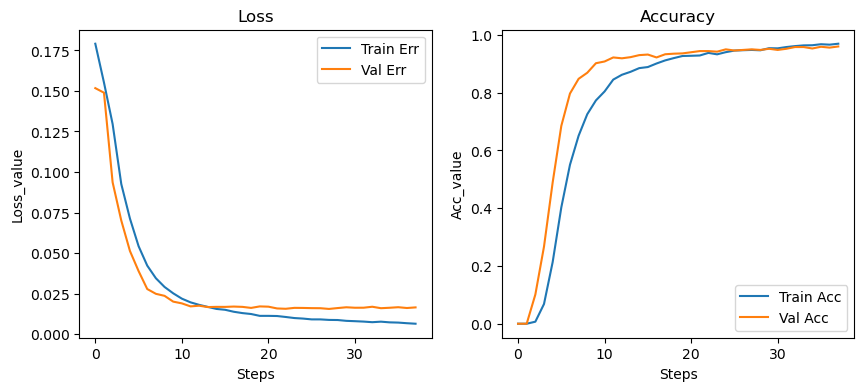

In [80]:
# show by matplot
loss_record = np.array(loss_record)
plt.figure(figsize = (10,4))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.xlabel('Steps')
plt.ylabel('Loss_value')
plt.plot(loss_record[:,0], label = 'Train Err')
plt.plot(loss_record[:,1], label = 'Val Err')
plt.legend()

acc_record = np.array(acc_record)
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.xlabel('Steps')
plt.ylabel('Acc_value')
plt.plot(acc_record[:,0], label = 'Train Acc')
plt.plot(acc_record[:,1], label = 'Val Acc')
plt.legend()

plt.show()

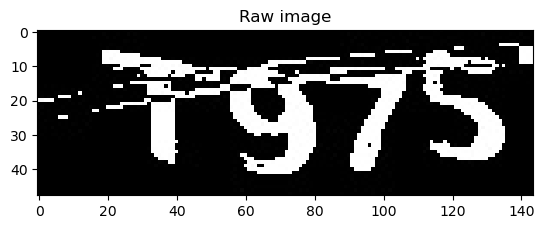

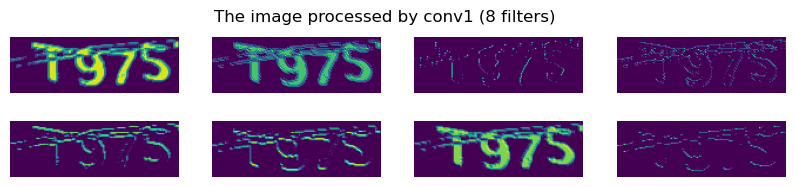

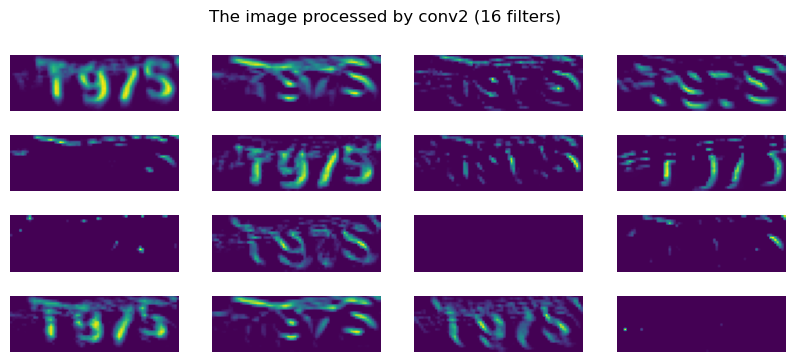

In [82]:
idx = 4545

img_path = config['processed_img_path']
img = cv2.imread(img_path + '/' + str(idx) + '.jpg')
plt.figure()
plt.title('Raw image')
plt.imshow(img)

img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).reshape([1, 48, 144])
x = img.reshape([1, 1, 48, 144])
input_x = torch.tensor(x, dtype = torch.float).to(device)
feature_maps = model.retrieve_features(input_x)

# Draw the 8 feature maps by conv1
plt.figure(figsize = (10, 2))
plt.suptitle('The image processed by conv1 (8 filters)')
for i1 in range(8):
    plt.subplot(2,4,i1 + 1)
    plt.axis('off')
    plt.imshow(feature_maps[0][0, i1])

# Draw the 16 feature maps by conv2
plt.figure(figsize = (10, 4))
plt.suptitle('The image processed by conv2 (16 filters)')
for i1 in range(16):
    plt.subplot(4,4,i1 + 1)
    plt.axis('off')
    plt.imshow(feature_maps[1][0, i1])